In [1]:
SAVE = False

Combine relevant evaluation files into a single file

In [10]:
import sys
sys.path.append('..')
import os
import pandas as pd
import eval_reallabor_utils
import data_utils

MRT = [2, 3]
combined_eval_file = []

for mrt in MRT:

    results_dirs = [
        f'v3_MRT{mrt}_Kalman_every_day/00_summary_7stepsahead_interv',
        f'v3_MRT{mrt}_Kalman_every_day/00_summary_7stepsahead_empirical_covariance',
        f'v3_MRT{mrt}_every_day/00_summary_7stepsahead_interv',
        f'v3_MRT{mrt}_every_day/00_summary_7stepsahead_empirical_covariance',
        ]

    eval_files = []
    for rd in results_dirs:
        eval_files.append(data_utils.join_ordinal_bptt_path('results', rd, 'evaluation.csv'))
        assert os.path.exists(eval_files[-1]), eval_files[-1]
    eval_reallabor_utils.clear_line_and_print(f'Combining evaluation files')
    mrt_combined_eval_file = eval_reallabor_utils.combine_evaluation_files(eval_files, save_path=None, specifier_name='version', specifier_values=['KF_traditional', 'KF_empirical_cov', 'PLRNN_traditional', 'PLRNN_empirical_cov'])
    mrt_combined_eval_file['MRT'] = mrt

    use_days_from_file = data_utils.train_test_split_path(mrt, 'valid_first_alarms_no_con_smoothed.csv')
    valid_days = pd.read_csv(use_days_from_file, index_col=0)
    valid_days.columns = [int(c) for c in valid_days.columns]

    eval_reallabor_utils.clear_line_and_print(f'Filtering out invalid days')
    eval_only_valid_days = []
    for p, group in mrt_combined_eval_file.groupby('participant'):
        if p in valid_days.columns:
            eval_only_valid_days.append(group.loc[group['test_day'].isin(valid_days[p])])
    mrt_combined_eval_file = pd.concat(eval_only_valid_days, axis=0, ignore_index=True)
    
    mrt_combined_eval_file['prediction'] = mrt_combined_eval_file['prediction'].clip(0, 8)

    combined_eval_file.append(mrt_combined_eval_file)

eval_reallabor_utils.clear_line_and_print(f'Creating grand combined evaluation file')
combined_eval_file = pd.concat(combined_eval_file, axis=0, ignore_index=False)
if not os.path.exists(data_utils.join_ordinal_bptt_path('results/_paper/combined_every_day_ensemble.csv')):
    os.makedirs(data_utils.join_ordinal_bptt_path('results/_paper'), exist_ok=True)
    combined_eval_file.to_csv(data_utils.join_ordinal_bptt_path('results/_paper/combined_every_day_ensemble.csv'))

if 'train_until' in combined_eval_file.columns:
    combined_eval_file.loc[combined_eval_file['latent_model']=='hierarchized clipped-shallow-PLRNN', 'latent_model'] = 'hierarchized-clipped-shallow-PLRNN'
    combined_eval_file.loc[combined_eval_file['train_until'].isna(), 'train_until'] = combined_eval_file.loc[combined_eval_file['train_until'].isna(), 'train_on_data_until_timestep']

Creating grand combined evaluation file                                                                                                                                                                 

Create metrics manager

In [11]:
from eval_reallabor import reallabor_metrics
m_manager = reallabor_metrics.MetricsManager(combined_eval_file, ['MRT', 'version'], use_gt_for_predicted_difference=False, only_nonzero_differences=True)

Use mean and standard error for confidence intervals

In [12]:
metrics, errorbars = {}, {}
# m_manager.raw_metrics.loc[(12, 2, 'KalmanFilter'), 'delta_interv_change_abs_residuals'] = np.nan
metrics['mae'] = m_manager.mae(func='mean')
errorbars['mae'] = m_manager.mae(func='sem')

metrics['interv mae'] = m_manager.interv_mae(func='mean')
errorbars['interv mae'] = m_manager.interv_mae(func='sem')

# metrics['change mae'] = m_manager.change_mae(func='mean')
# errorbars['change mae'] = m_manager.change_mae(func='sem')
# metrics['diff mae'] = m_manager.diff_mae(func='mean')
# errorbars['diff mae'] = m_manager.diff_mae(func='sem')

# metrics['change sign correct'] = m_manager.change_sign_correct(func='mean')
# errorbars['change sign correct'] = m_manager.change_sign_correct(func='sem')

# metrics[r'interv. effect mae'] = m_manager.interv_diff_mae(func='mean')
# errorbars[r'interv. effect mae'] = m_manager.interv_diff_mae(func='sem')
# metrics['delta interv effect mae'] = m_manager.delta_interv_diff_mae(func='mean')
# errorbars['delta interv effect mae'] = m_manager.delta_interv_diff_mae(func='sem')

# metrics['delta interv mae'] = m_manager.delta_interv_mae(func='mean')
# errorbars['delta interv mae'] = m_manager.delta_interv_mae(func='sem')
# metrics['interv change sign correct'] = m_manager.interv_change_sign_correct(func='mean')
# errorbars['interv change sign correct'] = m_manager.interv_change_sign_correct(func='sem')

Plot metrics

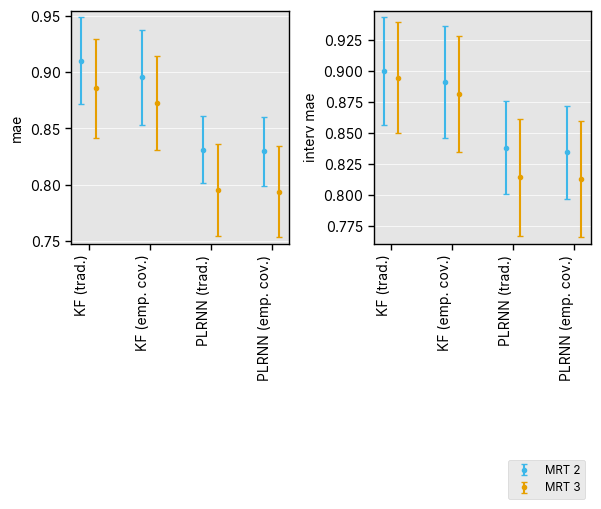

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle
from plotting_utils import adjust_ylim

model_labels = {
                    'KF_traditional': 'KF (trad.)',
                    'KF_empirical_cov': 'KF (emp. cov.)',
                    'PLRNN_traditional': 'PLRNN (trad.)',
                    'PLRNN_empirical_cov': 'PLRNN (emp. cov.)'
                    }

with PaperStyle():

    color_cycle = ["#3DB7E9", "#e69f00"]
    offset = [-0.12, 0.12]

    ''' COMBINE BOTH MRTS INTO ONE PLOT '''
    fig, axes = plt.subplots(1, len(metrics), figsize=(1+2.6*len(metrics), 4), sharex=True)
    axes = axes.flatten()
    for i, m in enumerate(metrics):
        for k, mrt in enumerate(MRT):
            this_line = metrics[m].loc[mrt].loc[model_labels.keys()]
            this_errorbars = errorbars[m].loc[mrt].loc[model_labels.keys()].T
            axes[i].errorbar(np.arange(len(model_labels))+offset[k], this_line, yerr=this_errorbars, linestyle='', marker='.', label=f'MRT {mrt}')
        ylim = axes[i].get_ylim()
        # for k, mrt in enumerate(MRT):
        #     for l, model in enumerate(model_labels.keys()):
        #         if sig[m].loc[(mrt, model), 'clipped-shallow-PLRNN']:
        #             axes[i].text(l+offset[k], ylim[1], '*', fontsize=12, color=color_cycle[k], ha='center', va='bottom')
        axes[i].set(ylabel=m, xticks=range(len(model_labels)))
        axes[i].set_xticklabels(model_labels.values(), rotation=90, ha='right')
        adjust_ylim(axes[i], 0.03, 0.03)
    plt.tight_layout()
    axes[-1].legend(bbox_to_anchor=(1, -0.9))
    if SAVE:
        plt.savefig('../results/_paper/model_comparison/model_comparison_every_day_ensemble.svg', dpi=300)

    plt.show()



Display metrics as table

In [16]:
model_labels = {
                    'KF_traditional': 'KF (trad.)',
                    'KF_empirical_cov': 'KF (emp. cov.)',
                    'PLRNN_traditional': 'PLRNN (trad.)',
                    'PLRNN_empirical_cov': 'PLRNN (emp. cov.)'
                    }


human_readable_metrics = (pd.DataFrame(metrics).loc[pd.IndexSlice[[2,3], model_labels.keys()], :].round(3).map(str)
                          + ' \u00b1 '
                          + pd.DataFrame(errorbars).loc[pd.IndexSlice[[2,3], model_labels.keys()], :].round(4).map(str))
human_readable_metrics

mae      interv mae
MRT version                                            
2   KF_traditional        0.91 ± 0.0385    0.9 ± 0.0434
    KF_empirical_cov     0.895 ± 0.0419  0.891 ± 0.0454
    PLRNN_traditional      0.831 ± 0.03  0.838 ± 0.0374
    PLRNN_empirical_cov  0.829 ± 0.0303  0.834 ± 0.0378
3   KF_traditional       0.886 ± 0.0439  0.894 ± 0.0449
    KF_empirical_cov     0.873 ± 0.0418  0.881 ± 0.0469
    PLRNN_traditional    0.795 ± 0.0407  0.814 ± 0.0469
    PLRNN_empirical_cov  0.794 ± 0.0407  0.812 ± 0.0468

Test MAE of all models against PLRNN with Pseudoinverse

In [22]:
test = m_manager.ttest

test_results = test('abs_residuals', separately_for_each=['MRT'])
test_results['pvalue'] *= test_results.index.get_level_values('version').unique().size - 1

if test==m_manager.ttest:
    human_readable_test_results = ('t(' 
                                   + test_results[('df', 'PLRNN_traditional')].astype(str)
                                   + ')='
                                   + test_results[('statistic', 'PLRNN_traditional')].map(lambda x: f"{x:.3f}")
                                   + ', p='
                                   + test_results[('pvalue', 'PLRNN_traditional')].map(lambda x: f"{x:.3f}"))
else:
    human_readable_test_results = ('W='
                                   + test_results[('statistic', 'PLRNN_traditional')].map(lambda x: f"{x:.3f}")
                                   + ', p='
                                   + test_results[('pvalue', 'PLRNN_traditional')].map(lambda x: f"{x:.3f}"))

human_readable_test_results

MRT  version            
2    KF_empirical_cov        t(45)=1.958, p=0.169
     KF_traditional          t(45)=3.861, p=0.001
     PLRNN_empirical_cov    t(47)=-1.692, p=0.292
     PLRNN_traditional           t(47)=nan, p=nan
3    KF_empirical_cov        t(45)=2.108, p=0.122
     KF_traditional          t(45)=2.260, p=0.086
     PLRNN_empirical_cov    t(50)=-1.759, p=0.254
     PLRNN_traditional           t(50)=nan, p=nan
dtype: object

Test MAE of all models against PLRNN with empirical Covariance

In [17]:
test = m_manager.ttest

test_results = test('abs_residuals', separately_for_each=['MRT'])
test_results['pvalue'] *= test_results.index.get_level_values('version').unique().size - 1

if test==m_manager.ttest:
    human_readable_test_results = ('t(' 
                                   + test_results[('df', 'PLRNN_empirical_cov')].astype(str)
                                   + ')='
                                   + test_results[('statistic', 'PLRNN_empirical_cov')].map(lambda x: f"{x:.3f}")
                                   + ', p='
                                   + test_results[('pvalue', 'PLRNN_empirical_cov')].map(lambda x: f"{x:.3f}"))
else:
    human_readable_test_results = ('W='
                                   + test_results[('statistic', 'PLRNN_empirical_cov')].map(lambda x: f"{x:.3f}")
                                   + ', p='
                                   + test_results[('pvalue', 'PLRNN_empirical_cov')].map(lambda x: f"{x:.3f}"))

human_readable_test_results

MRT  version            
2    KF_empirical_cov       t(45)=2.024, p=0.147
     KF_traditional         t(45)=3.937, p=0.001
     PLRNN_empirical_cov        t(47)=nan, p=nan
     PLRNN_traditional      t(47)=1.692, p=0.292
3    KF_empirical_cov       t(45)=2.174, p=0.105
     KF_traditional         t(45)=2.325, p=0.074
     PLRNN_empirical_cov        t(50)=nan, p=nan
     PLRNN_traditional      t(50)=1.759, p=0.254
dtype: object